In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/'

!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.5MB/s]
100% 542M/543M [00:07<00:00, 59.3MB/s]
100% 543M/543M [00:07<00:00, 77.8MB/s]
 98% 266M/271M [00:05<00:00, 66.2MB/s]
100% 271M/271M [00:05<00:00, 47.7MB/s]


In [12]:
import tensorflow as tf
import shutil

In [13]:
!unzip -q train.zip -d .

In [14]:
#print(len(os.listdir('/content/train/')))

cat이 들은 data는 cat 폴더로, dog이 들은 data는 dog 폴더로 이동합니다.

In [17]:
#os.mkdir('/content/dataset')
#os.mkdir('/content/dataset/cat')
#os.mkdir('/content/dataset/dog')

FileExistsError: ignored

In [16]:


for i in os.listdir('/content/train/'):
  if 'cat' in i:
    shutil.copyfile('/content/train/'+i,'/content/dataset/cat/'+i)
  if 'dog' in i:
    shutil.copyfile('/content/train/'+i,'/content/dataset/dog/'+i) 


train_ds는 데이터중 80%를, val_ds는 데이터 중 20%를 차지합니다.  
train_Ds는 ((이미지2만개),(정답2만개))입니다. 

In [18]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size=(64,64),
    batch_size=64,
    subset='training',
    validation_split=0.2,  # validation data로 20%를 쓰겠다는 뜻입니다.
    seed=1234
)
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size=(64,64),
    batch_size=64,
    subset='validation',
    validation_split=0.2,# validation data로 20%를 쓰겠다는 뜻입니다.
    seed=1234
)

print(train_ds)
def 전처리함수(i, 정답):
  i=tf.cast(i/255.0,tf.float32)
  return i, 정답

train_ds=train_ds.map(전처리함수)
val_ds=val_ds.map(전처리함수)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>


버그가 생겼습니다. 개와 고양이인데 어찌 3classes인것이죠 dataset을 삭제하겠습니다. 그리고 파이썬 코드로 다시만들죠죠

In [ ]:
#%rm -rf dataset

텐서를 넘파이어레이라고 붙여주어야합니다.

<MapDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>
tf.Tensor(
[[[[0.08425054 0.02934857 0.02542701]
   [0.0788603  0.02395833 0.02003676]
   [0.09209559 0.04895834 0.03327206]
   ...
   [0.06710516 0.02360026 0.00803654]
   [0.07450981 0.01960784 0.01568628]
   [0.00392923 0.00803654 0.00392923]]

  [[0.1010972  0.0501168  0.02658739]
   [0.119267   0.06828661 0.0447572 ]
   [0.06590265 0.03845167 0.01492226]
   ...
   [0.07071079 0.02720588 0.01164216]
   [0.06977443 0.01487247 0.0109509 ]
   [0.00349839 0.01146408 0.00509153]]

  [[0.09571078 0.04473039 0.01335784]
   [0.09761029 0.0466299  0.01525735]
   [0.07900965 0.066142   0.03922909]
   ...
   [0.07178692 0.02703546 0.01188726]
   [0.0753753  0.02147863 0.01722197]
   [0.00857843 0.01602137 0.00982307]]

  ...

  [[0.3947572  0.32857114 0.24108073]
   [0.46586245 0.3835095  0.26279873]
   [0.5416322  0.4666322  0.34874004]
   ...
   [0.46569967 0.29682714 0.0887389 ]
   [0.37026656 0.20948224 0.007

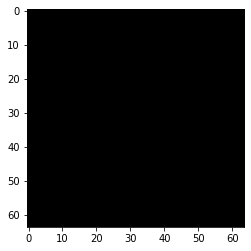

In [19]:
print(train_ds)
import matplotlib.pyplot as plt
for i, 정답 in train_ds.take(1):
  print(i)
  print(정답)
  plt.imshow(i[0].numpy().astype('uint8'))
  plt.show() 

이미 train_ds에는 ((이미지들),(정답)) 형식으로 구성되어 있으므로 파라미터에 train_ds 하나만 넣어주면 됩니다.  

또한 모델에 넣기 전에 이미지 augmentation을 진행해 줄 수 있습니다. epoch이 10번이면 전부 다른버전의 이미지가 들어가겠죠?

In [20]:
model=tf.keras.Sequential([
                           
   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(64,64,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),  

   tf.keras.layers.Conv2D(32,(3,3),padding="same",activation='relu',input_shape=(64,64,3) ),
   tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(64,64,3) ),
   tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Conv2D(128,(3,3),padding="same",activation='relu',input_shape=(64,64,3) ),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128,activation="relu"),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation="sigmoid"),
])
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
model.fit(train_ds,validation_data=val_ds,epochs=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 64, 64, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 3)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

텐서플러우의 모든 전처리 레이어가 설명된 링크입니다.

최근 나온 쉬운 방식의 이미지 증강 방식이며,
> tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(64,64,3)),
>tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
>tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),  

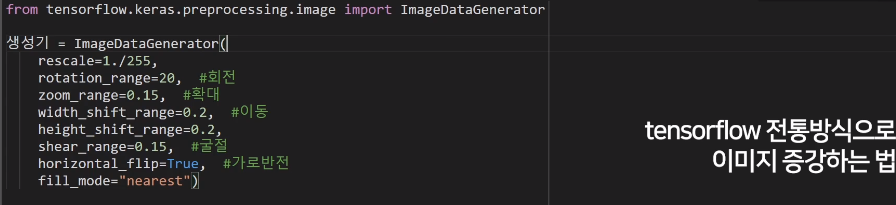
